In [1]:
import numpy as np

# Save fonts into pdf
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


import matplotlib.pyplot as plt
import tqdm.notebook
import scipy.integrate

In [2]:
matplotlib.rcParams.update({'font.size': 8, 'axes.linewidth': 0.5, 'xtick.major.width': 0.5, 'xtick.minor.width': 0.5, 
                            'ytick.major.width': 0.5,'ytick.minor.width': 0.5, 'xtick.major.pad':2,'ytick.major.pad':2})
matplotlib.rcParams.update({'font.family':'sans-serif','font.sans-serif':['Arial'], 'mathtext.default':'sf','mathtext.fontset':'custom'})

matplotlib.rcParams.update({'savefig.transparent':True})

In [3]:
dt = 1e-4
T_max = 0.2
t = np.arange(0, int(T_max/dt))*dt

In [5]:
uni_distr = np.exp(-(t-0.12)**2/(2*0.0075**2))
uni_distr /=np.sum(uni_distr)

In [6]:
uniform_distr = np.ones(len(t))
uniform_distr /= np.sum(uniform_distr)

peak_weight = 0.1
peaked_distr = peak_weight*uni_distr + (1-peak_weight)*uniform_distr

In [102]:
uniform_cdf = np.cumsum(uniform_distr)
get_interval_unif = lambda r: np.interp(r, uniform_cdf, t)

In [7]:
# uniform_cdf = np.cumsum(uniform_distr)
peaked_cdf = np.cumsum(peaked_distr)
get_interval_peaked = lambda r: np.interp(r, peaked_cdf, t)

In [42]:
idealized_integrator = lambda t, t_p: np.exp(-(t-t_p)**2/(2*0.0025**2))

def simulateTimerAdjustmentPeak(get_interval, N_sims = 10, its = 5000, 
                                dtp_ = 1e-3, min_tp = 0, max_tp = T_max, report_its = 100,
                               window_left = 20e-3, window_right = 20e-3, median_weight = 0.01, initial_value = None):
    tps = np.zeros((N_sims, int(its/report_its)))
    # cdf = np.cumsum(distr)
    # get_interval = lambda r: np.interp(r, cdf, t)
    
    if initial_value == None:
        initial_value = min_tp
    

    for n in tqdm.notebook.trange(N_sims):
        integrator = idealized_integrator(t, min_tp)
        report_ind = 0
        tp = initial_value

        # tps[n, 0] = initial_value
        for it in tqdm.notebook.trange(its-1, leave=False):
            cf_time = get_interval(rng.random())

            # Idealized ATTRAP rule: lower threshold if CF occurs before current peak time
            # and raise threshold if CF occurs after current peak time
            # lower_tp_med = -1*(cf_time < tps[n, it])
            lower_tp_med = -1*(cf_time < tp)
            # raise_tp_med = cf_time > tps[n, it]
            raise_tp_med = cf_time > tp

            dtp_med = lower_tp_med+raise_tp_med
            
            # lower_tp_window = -1*(tps[n,it]-window_left < cf_time < tps[n, it])
            lower_tp_window = -1*(tp-window_left < cf_time < tp)
            # raise_tp_window = tps[n, it] < cf_time < tps[n,it] + window_right
            raise_tp_window = tp < cf_time < tp + window_right
            
            dtp_window = lower_tp_window+raise_tp_window
            
            dtp = dtp_*(median_weight*dtp_med + (1-median_weight)*dtp_window)
            # tps[n,it+1] = np.minimum(np.maximum(tps[n,it] + dtp, min_tp), max_tp)

            tp += dtp
            integrator = idealized_integrator(t, tp + dtp)
            
            if it % report_its == 0:
                tps[n, report_ind] = tp
                report_ind += 1
    return tps

In [15]:
rng = np.random.default_rng(seed=0)

In [56]:
tps_ideal_asym = simulateTimerAdjustmentPeak(get_interval_peaked,dtp_=5e-4, initial_value=0., window_right=19e-3,
                                               its=500000, N_sims=10,median_weight=0.01, report_its=1000)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/499999 [00:00<?, ?it/s]

  0%|          | 0/499999 [00:00<?, ?it/s]

  0%|          | 0/499999 [00:00<?, ?it/s]

  0%|          | 0/499999 [00:00<?, ?it/s]

  0%|          | 0/499999 [00:00<?, ?it/s]

  0%|          | 0/499999 [00:00<?, ?it/s]

  0%|          | 0/499999 [00:00<?, ?it/s]

  0%|          | 0/499999 [00:00<?, ?it/s]

  0%|          | 0/499999 [00:00<?, ?it/s]

  0%|          | 0/499999 [00:00<?, ?it/s]

In [57]:
trial_t = np.arange(tps_ideal_asym.shape[1])

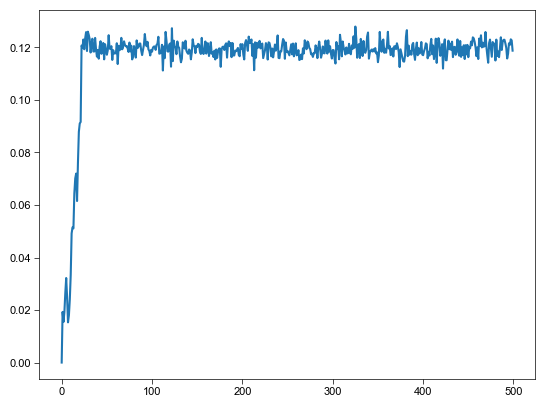

In [58]:
plt.plot(trial_t, tps_ideal_asym[0,:])

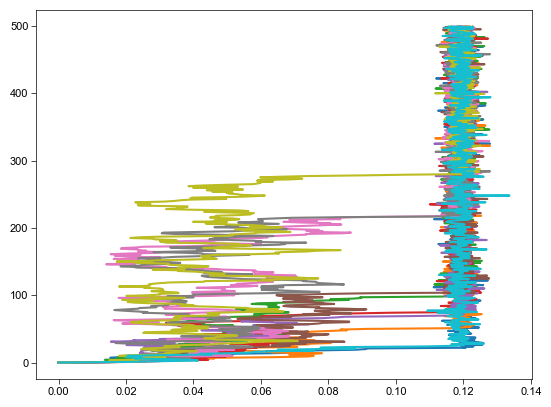

In [59]:
for i in range(tps_ideal_asym.shape[0]):
    plt.plot(tps_ideal_asym[i,:], trial_t) # , c=[c[i],]*3)

In [65]:
uniform_cdf_fn = lambda r: np.interp(r, t, uniform_cdf,left=0,right=1)
peaked_cdf_fn = lambda r: np.interp(r, t, peaked_cdf,left=0,right=1)

In [66]:
median_weight = 1e-2
window_size = [20e-3, 19e-3]
expected_delta_tp_fn = lambda tp,fn: -(median_weight*(2*fn(tp)-1)+
                                (1-median_weight)*(2*fn(tp) - fn(tp-window_size[0]) -
                                                  fn(tp+window_size[1])))

expected_delta_tp_unif = lambda tp: expected_delta_tp_fn(tp, uniform_cdf_fn)
expected_delta_tp_peaked = lambda tp: expected_delta_tp_fn(tp, peaked_cdf_fn)

In [90]:
tp_phase = np.linspace(0.01, 0.19, 10) # 8
tt_phase = np.linspace(50000, 450000, 4)

tpp, ttt = np.meshgrid(tp_phase, tt_phase)

In [91]:
dtpp = expected_delta_tp_peaked(tpp)
dttt = np.ones(ttt.shape)

dtpp_norm = dtpp/np.sqrt(dtpp**2 + dttt**2)
dttt_norm = dttt/np.sqrt(dtpp**2 + dttt**2)

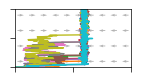

In [100]:
plt.figure(figsize=(1.5,0.75))
plt.quiver(tpp, ttt, dtpp_norm, dttt_norm, angles='xy', pivot='middle', color=(0.7,)*3)
plt.plot([0.12,]*2, [0, trial_t[-1]], c='r')
plt.plot([0.0615,]*2, [0, trial_t[-1]], c='r') # c=(0.3,)*3)
c = np.linspace(0,0.8,10)
for i in range(10):
    plt.plot(tps_ideal_asym[i,:], trial_t*1000,lw=1) # , c=[c[i],]*3)


plt.xlim([0, 0.2])
plt.ylim([0, 500000])

ax = plt.gca()
ax.set_yticks([0, 250000, 500000])
ax.set_yticklabels([])
ax.set_xticks([0, 0.1, 0.2])
ax.set_xticklabels([])
plt.savefig('figures/ideal-selection-narrow-asym-phase.pdf')

In [127]:
tps_ideal_asym_peaked_mu = np.mean(tps_ideal_asym,axis=0)

In [128]:
tps_ideal_asym_peaked_mu.shape

(500,)

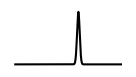

In [130]:

plt.figure(figsize=(1.5,0.75))
plt.plot(t, idealized_integrator(t, np.mean(tps_ideal_asym_peaked_mu[-10:])),c='k')
plt.axis('off')

plt.savefig('figures/ideal-selection-narrow-asym-eligibility-peaked.pdf')

In [103]:
tp_ideal_asym = simulateTimerAdjustmentPeak(get_interval_unif,dtp_=5e-4, initial_value=0.12, window_right=19e-3,
                                               its=500000, N_sims=10,median_weight=0.01, report_its=1000)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/499999 [00:00<?, ?it/s]

  0%|          | 0/499999 [00:00<?, ?it/s]

  0%|          | 0/499999 [00:00<?, ?it/s]

  0%|          | 0/499999 [00:00<?, ?it/s]

  0%|          | 0/499999 [00:00<?, ?it/s]

  0%|          | 0/499999 [00:00<?, ?it/s]

  0%|          | 0/499999 [00:00<?, ?it/s]

  0%|          | 0/499999 [00:00<?, ?it/s]

  0%|          | 0/499999 [00:00<?, ?it/s]

  0%|          | 0/499999 [00:00<?, ?it/s]

In [104]:
tp_ideal_asym_unif_mu = np.mean(tp_ideal_asym, axis=0)
tp_ideal_asym_unif_std = np.std(tp_ideal_asym, axis=0)

In [105]:
dtpp = expected_delta_tp_unif(tpp)
dttt = np.ones(ttt.shape)

dtpp_norm = dtpp/np.sqrt(dtpp**2 + dttt**2)
dttt_norm = dttt/np.sqrt(dtpp**2 + dttt**2)

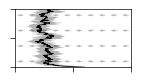

In [117]:
plt.figure(figsize=(1.5,0.75))
plt.quiver(tpp, ttt, dtpp_norm, dttt_norm, angles='xy', pivot='middle', color=(0.7,)*3)
# plt.plot([0.05,]*2, [0, trial_t[-1]], c='r')
# plt.plot([0.0615,]*2, [0, trial_t[-1]], c='r') # c=(0.3,)*3)
# c = np.linspace(0,0.8,10)
# for i in range(10):
#     plt.plot(thresholds_ideal_asym[i,::1000], trial_t[::1000]) # , c=[c[i],]*3)

plt.plot(tp_ideal_asym_unif_mu, trial_t*1000, c='k',lw=0.5)
# plt.plot((tp_ideal_asym_unif_mu-tp_ideal_asym_unif_std), trial_t*1000, c=(0.5,)*3)
# plt.plot((tp_ideal_asym_unif_mu+tp_ideal_asym_unif_std), trial_t*1000, c=(0.5,)*3)
# plt.plot(thresholds_ideal_2_mu, trial_t)
plt.fill_betweenx(trial_t*1000, tp_ideal_asym_unif_mu - tp_ideal_asym_unif_std,tp_ideal_asym_unif_mu + tp_ideal_asym_unif_std, facecolor='k', alpha=0.3 )
# plt.fill_betweenx(trial_t, thresholds_ideal_2_mu - thresholds_ideal_2_std,thresholds_ideal_2_mu + thresholds_ideal_2_std, facecolor='C1', alpha=0.3 )

plt.xlim([0, 0.2])
plt.ylim([0, 500000])

ax = plt.gca()
ax.set_yticks([0, 250000, 500000])
ax.set_yticklabels([])
ax.set_xticks([0, 0.1, 0.2])
ax.set_xticklabels([])
plt.savefig('figures/ideal-selection-narrow-asym-phase-unif.pdf')

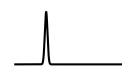

In [131]:

plt.figure(figsize=(1.5,0.75))
plt.plot(t, idealized_integrator(t, np.mean(tp_ideal_asym_unif_mu[-10:])),c='k')
plt.axis('off')

plt.savefig('figures/ideal-selection-narrow-asym-eligibility-unif.pdf')

# Biased WTA

In [166]:
num_ideal_timers = 14
timers = np.zeros((num_ideal_timers, len(t)))
centers = np.linspace(0, 0.2, num_ideal_timers+1)[:-1]
width = centers[1]/2
centers += width
for i in range(num_ideal_timers):
    timers[i,:] = np.exp(-(t - centers[i])**2/(2*(width)**2))

In [167]:
centers

array([0.00714286, 0.02142857, 0.03571429, 0.05      , 0.06428571,
       0.07857143, 0.09285714, 0.10714286, 0.12142857, 0.13571429,
       0.15      , 0.16428571, 0.17857143, 0.19285714])

In [150]:
timer_max = np.zeros((num_ideal_timers, len(t)))
for i in range(len(t)):
    timer_max[np.argmax(timers[:,i]),i] = 1

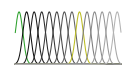

In [186]:
plt.figure(figsize=(1.5,0.75))

c_ = np.linspace(0, 0.7,num_ideal_timers)
for i in range(num_ideal_timers):
    if i == 0:
        c_str = 'C2'
    elif i == 8:
        c_str = 'C8'
    else:
        c_str = [c_[i],]*3
    plt.plot(t, timers[i,:], c=c_str,lw=0.75)
plt.axis('off')
plt.savefig('figures/ideal-selection-biased-timers.pdf')

In [161]:
def selectionFixedBias(v_initial, get_interval, its=5000000, dv_max = 1e-4, report_its = 10000, dv_zero = 0.9e-4):
    """Simulate ATTRAP with fixed update method of timer selection mechanism.
    
    Arguments:
    v_initial -- initial vector of eligibility coupling weights
    distr -- distribution of PF/CF intervals
    its -- total number of PF/CF presentations (iterations) to simulate
    dv -- "Delta", the amount by which to decrease coupling weights for inactive timers
    report_its -- Frequency (in iterations) of reporting output weight vector
    
    Returns:
    v -- final weight vector
    v_all -- weight vector reported at intervals specified by report_its
    """
    
    # cdf = np.cumsum(distr/np.sum(distr))

    # Use CDF to draw intervals randomly from distribution given uniform random variables (see Methods)
    # get_interval = lambda r: np.interp(r, cdf, t)
    # get_interval_NN = lambda r: np.array(np.round(get_interval(r)*10000)/10000/dt, dtype=int)
    
    # Used for reporting weight values periodically
    report_counter = 0
    report_index = 1

    num_states = timers.shape[0]
    
    dv = dv_max*np.ones(num_states)
    dv[0] = dv_zero
    # active_v_threshold = dv/num_states

    # num_updates = np.zeros(num_states)

    v_all = np.zeros((num_states, int(its/report_its)+1))
    v_all[:,0] = np.copy(v_initial)
    v = np.copy(v_initial)

    for it in tqdm.notebook.trange(its, leave=False):
        # Calculate values of most active basis function
        # given random draw of PF/CF interval
        cf_spike_ind = np.digitize(get_interval(rng.random()), t)-1
        timer_vals = timers[:,cf_spike_ind]

        # Get index of most active timer
        active_timer = np.argmax(timer_vals)

        # Shouldn't end up with negative weights
        timers_to_update = (v>0)
        timers_to_update[active_timer] = False
        num_active_timers = np.sum(timers_to_update)

        if num_active_timers > 0:
            dv_minus = np.zeros(num_states)
            # Decrease coupling weights of all timers except the most active (ind_to_increase)
            dv_minus[timers_to_update] = np.minimum(v[timers_to_update], dv[timers_to_update])
            dv_minus[active_timer] = 0

            # Add weight changes
            v -= dv_minus
            
            v[active_timer] += np.sum(dv_minus)

        report_counter += 1
        # Save current weight vector periodically
        if report_counter == report_its:
            v_all[:, report_index] = np.copy(v)
            report_counter = 0
            report_index += 1
    return v, v_all

In [162]:
v_initial = np.zeros(num_ideal_timers)
v_initial[0] = 1

v_fixed_ideal_peaked, v_fixed_ideal_all_peaked = selectionFixedBias(v_initial, get_interval_peaked, its=75000, report_its=1000,
                                                  dv_max=1e-4, dv_zero = 0.9e-4)

  0%|          | 0/75000 [00:00<?, ?it/s]

In [164]:
v_initial = v_fixed_ideal_peaked # np.zeros(num_ideal_timers)
# v_initial[0] = 1

v_fixed_ideal_unif, v_fixed_ideal_all_unif = selectionFixedBias(v_initial, get_interval_unif, its=500000, report_its=10000,
                                                  dv_max=1e-4, dv_zero = 0.9e-4)

  0%|          | 0/500000 [00:00<?, ?it/s]

In [ ]:
plt.fill_between(t, np.zeros(len(t)), peaked_distr, color=(0.9,)*3)
ax = plt.twinx()
ax.plot(t, v_fixed_ideal_peaked@timers,c='k')

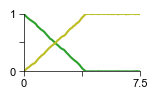

In [184]:
plt.figure(figsize=(1.5,0.75))

it_report = 1000
x = np.arange(v_fixed_ideal_all_peaked.shape[1])*it_report
plt.plot(x, v_fixed_ideal_all_peaked[0,:], c='C2')
plt.plot(x, v_fixed_ideal_all_peaked[8,:], c='C8')
ax = plt.gca()
plt.ylim([0,1])
plt.xlim([0, 75000])
ax.set_xticks([0, 75000/2, 75000])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels([0,'',7.5])
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels([0,'',1])
plt.savefig('figures/ideal-selection-biased-weights-peaked.pdf')

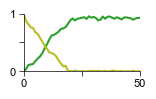

In [185]:
plt.figure(figsize=(1.5,0.75))

it_report = 10000
x = np.arange(v_fixed_ideal_all_unif.shape[1])*it_report
plt.plot(x, v_fixed_ideal_all_unif[0,:],c='C2')
plt.plot(x, v_fixed_ideal_all_unif[8,:], c='C8')

ax = plt.gca()
plt.ylim([0,1])
ax.set_xticks([0, 75000/2, 75000])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels([0,'',7.5])
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels([0,'',1])

ax = plt.gca()
plt.ylim([0,1])
plt.xlim([0, 500000])
ax.set_xticks([0, 250000, 500000])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels([0,'',50])
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels([0,'',1])

# ax = plt.gca()
# ax.set_yticks([0, 250000, 500000])
# ax.set_yticklabels([])
# ax.set_xticks([0, 0.5, 1])
# ax.set_xticklabels([])
plt.savefig('figures/ideal-selection-biased-weights-unif.pdf')